Simple DCGAN for MNIST Digit Generation
.This demonstrates how to build and train a simple GAN using PyTorch to generate handwritten digits using the MNIST dataset.

In [1]:
# Install and import libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    batch_size=128, shuffle=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 471kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.38MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.92MB/s]


In [3]:
# Define the Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 784),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.model(x)
        return x.view(-1, 1, 28, 28)

In [4]:
# Define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

In [5]:
# Initialize models, loss, and optimizers
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = Generator().to(device)
D = Discriminator().to(device)
criterion = nn.BCELoss()
opt_G = torch.optim.Adam(G.parameters(), lr=0.0002)
opt_D = torch.optim.Adam(D.parameters(), lr=0.0002)

In [6]:
# Training loop
epochs = 5
for epoch in range(epochs):
    for real, _ in dataloader:
        real = real.to(device)
        b_size = real.size(0)

        noise = torch.randn(b_size, 100, device=device)
        fake = G(noise)

        D_real = D(real)
        D_fake = D(fake.detach())

        D_loss_real = criterion(D_real, torch.ones_like(D_real))
        D_loss_fake = criterion(D_fake, torch.zeros_like(D_fake))
        D_loss = D_loss_real + D_loss_fake

        opt_D.zero_grad()
        D_loss.backward()
        opt_D.step()

        output = D(fake)
        G_loss = criterion(output, torch.ones_like(output))
        opt_G.zero_grad()
        G_loss.backward()
        opt_G.step()
    print(f"Epoch [{epoch+1}/{epochs}] - D Loss: {D_loss.item():.4f}, G Loss: {G_loss.item():.4f}")

Epoch [1/5] - D Loss: 0.8122, G Loss: 0.9333
Epoch [2/5] - D Loss: 0.6086, G Loss: 1.4188
Epoch [3/5] - D Loss: 0.7007, G Loss: 1.3494
Epoch [4/5] - D Loss: 0.9424, G Loss: 1.3780
Epoch [5/5] - D Loss: 1.1484, G Loss: 1.0437


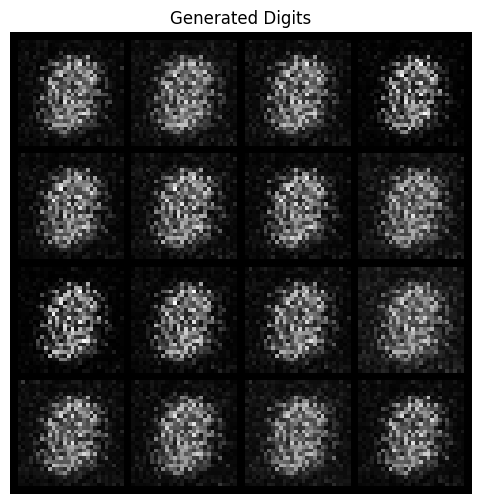

In [7]:
# Generate and display sample images
noise = torch.randn(16, 100, device=device)
fake_images = G(noise).cpu().detach()
grid = make_grid(fake_images, nrow=4, normalize=True)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title("Generated Digits")
plt.show()